# FORECASTING DE DEMANDA INTERMITENTE (05/06/2025)

1. **Preprocesamiento de los Datos**:
    - **Conversión de fechas**: Convertir la columna `CODE_MONTH` en una columa de fecha para facilitar el análisis de series temporales.
    - **Indetificación de productos únicos**: Al tener varios productos en el dataset, se puede analizar por separado o agrupar ciertos productos según características.
    - **Manejo de valores faltantes**: Asegúrate de que no haya valores faltantes en `TOTAL_AMOUNT`. S los hay, podrías optar por interpolación, imputación, o análisis separados.
    - **Creación de características temporales**: Generar columna como **mes**, **día de la semana**, **estacionalidad**, **tendencia**, entre otros.

2. **Análisis Exploratorio**:
    - Graficar la demanda para algunos productos seleccionados y observar patrones estacionales o de tendencias.
    - Revisar la distribución de la demanda para cada producto.

3. **Modelos de Forecasting**:
    **Modelos Estadísticos Tradicionales**:
    - **Método de Croston**: Ideal para series con muchas demandas nulas o intermitentes.
    - **ARIMA (AutoRegressive Integrated Moving Average)**: Bueno para series temporales con tendencia o estacionalidad.

    **Modelos de Machine Learning**:
    - **LightGBM / XGBoost / CatBoost**: Son adecuados para predicción de series temporales cuando se agregan características temporales como el mes, la tendencia y estacionalidad.
    - **Random Forest**: Similar a los métodos anteriores, pero también efectivo para series con patrones complejos no lineales.

    **Modelos de Deep Learning**:
    - **LSTM (Long Short-Term Memory)**: Si tienes suficiente cantidad de datos y necesitas modelar dependencias de largo plazo en las series temporales.
    - **GRU (Gated Recurrent Units)**: Alternativa a LSTM, igualmente útil para secuencias largas.

4. **Evaluación de los Modelos**:
    Utiliza métricas como **MAE** (Mean Absolute Error), **RMSE** (Root Mean Squared Error), y **MAPE** (Mean Absolute Percentage Error) para evluar el rendimiento de los modelos.

5. **Comparación de Modelos**:
    Compara el rendimiento de los modelos utlizando validación cruzada y/o un conjunto de test temporal.

6. **Librerías recomendadas**:
    - **`pandas`**: Para manipulación de datos.
    - **`matplotlib`** / **`seaborn`**: Para visualización de las series temporales y análisis exploratorio.
    - **`statsmodels`**: Para modelos tradicionales de series temporales (ARIMA, Holt-Winters).
    - **`sktime`**: Para implementación de modelos de forecasting como Croston y otros.
    - **`scikit-learn`**: Para modelos de Machine Learning como Random Forest, XGBoost, y LightGBM.
    - **`keras`** / **`tensorflow`**: Para Deep Learning con LSTM y GRU.

In [1]:
# ==================================================================================================== #
# ==================================================================================================== #
# PREPROCESAMIENTO DE LOS DATOS
# ==================================================================================================== #
# ==================================================================================================== #

In [2]:
# ==================================================================================================== #
# 1. CARGAR EL ARCHIVO
# ==================================================================================================== #

In [3]:
import pandas as pd

In [4]:
# Ruta del archivo en máquina local
file_path = r"C:\OneDrive\OneDrive - IMPERIA SCM CONSULTING, S.L\MyPyProjects\Pro000\Noel_Test.xlsx"

# Cargar el archivo
df = pd.read_excel(file_path)

# Ver las primeras filas del DataFrame
print(df.head())

   PRODUCT_CODE  CODE_MONTH  TOTAL_AMOUNT
0         12808      201902      177840.0
1         12808      201905      170372.0
2         12808      201906      149760.0
3         12808      201907       19968.0
4         12808      201910      151424.0


In [5]:
# ==================================================================================================== #
# 2. CONVERSIÓN DE LA COLUMNA CODE_MONTH A FORMATO DE FECHA
# ==================================================================================================== #

In [6]:
# Convertir CODE_MONTH a formato datetime
df['DATE'] = pd.to_datetime(df['CODE_MONTH'], format='%Y%m')

# Crear un rango de fechas con todos los meses posibles
start_date = df['DATE'].min()
end_date = df['DATE'].max()

# Generar todas las fechas de cada mes entre start_date y end_date
all_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

# Obtener todos los productos únics
product_codes = df['PRODUCT_CODE'].unique()

# Crear un DataFrame con todos las combinaciones de productos y fechas
all_combinations = pd.MultiIndex.from_product([product_codes, all_dates], names=['PRODUCT_CODE', 'DATE'])

# Unir el DataFrame con todas las combinaciones de productos y fechas
df_full = pd.DataFrame(index=all_combinations).reset_index()

# Hacer un merge con el DataFrame original para rellenar los valore de demanda
df_full = df_full.merge(df[['PRODUCT_CODE', 'DATE', 'TOTAL_AMOUNT']], on=['PRODUCT_CODE', 'DATE'], how='left')

# Rellenar los valores faltantes de 'TOTAL_AMOUNT' con 0.0 (float)
df_full['TOTAL_AMOUNT'] = df_full['TOTAL_AMOUNT'].fillna(0).astype(float)

# Verificar la conversión
print(df_full.head())

   PRODUCT_CODE       DATE  TOTAL_AMOUNT
0         12808 2019-01-01           0.0
1         12808 2019-02-01      177840.0
2         12808 2019-03-01           0.0
3         12808 2019-04-01           0.0
4         12808 2019-05-01      170372.0


In [7]:
# ==================================================================================================== #
# 3. MANEJO DE VALORES FALTANTES
# ==================================================================================================== #

In [8]:
# Se debe verificar si existen valores faltantes en las columnas. 
# Si los hay, se puede optar por diferentes estrategias (imputación o eliminación de filas)

# Verificar valores faltantes
print(df_full.isnull().sum())

# Si hay valores faltantes, puedes eliminar filas o imputar
#df = df.fillna(0)  # O puedes usar un método de imputación, como df.fillna()


PRODUCT_CODE    0
DATE            0
TOTAL_AMOUNT    0
dtype: int64


In [9]:
# ==================================================================================================== #
# 4. GENERACIÓN DE CARACTERÍSTICAS TEMPORALES
# ==================================================================================================== #

In [10]:
# Es recomendable generar características adicionales para el análisis de series temporales, 
# como el mes, el día de la semana, la estacionalidad, etc.

# Extraer mes y año de la columna DATE
df_full['YEAR'] = df_full['DATE'].dt.year
df_full['QUARTER'] = df_full['DATE'].dt.quarter
df_full['MONTH'] = df_full['DATE'].dt.month

# Mostrar las nuevas columnas
print(df_full.head())

   PRODUCT_CODE       DATE  TOTAL_AMOUNT  YEAR  QUARTER  MONTH
0         12808 2019-01-01           0.0  2019        1      1
1         12808 2019-02-01      177840.0  2019        1      2
2         12808 2019-03-01           0.0  2019        1      3
3         12808 2019-04-01           0.0  2019        2      4
4         12808 2019-05-01      170372.0  2019        2      5


In [11]:
# ==================================================================================================== #
# 5. VISUALIZACIÓN INICIAL
# ==================================================================================================== #

In [12]:
# Antes de proceder con los modelos, es útil visualizar las demandas para obtener una comprensión inicial.

import matplotlib.pyplot as plt

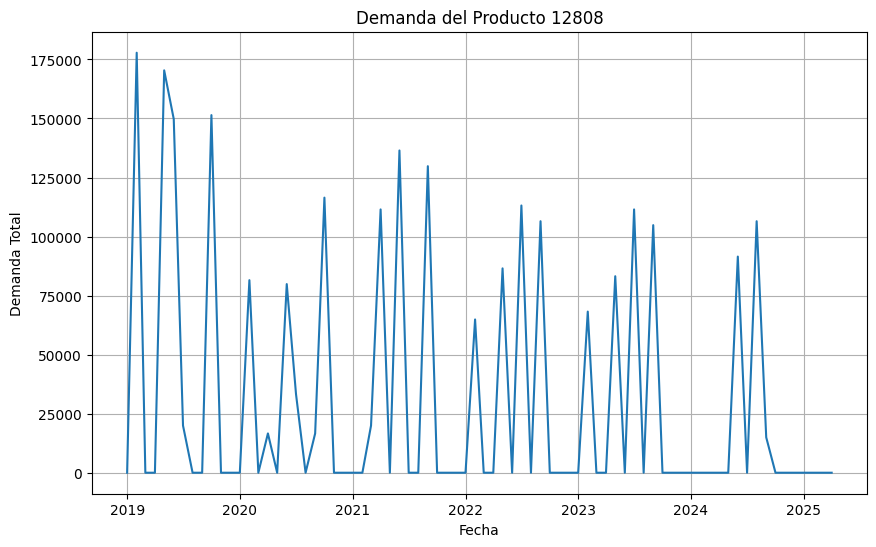

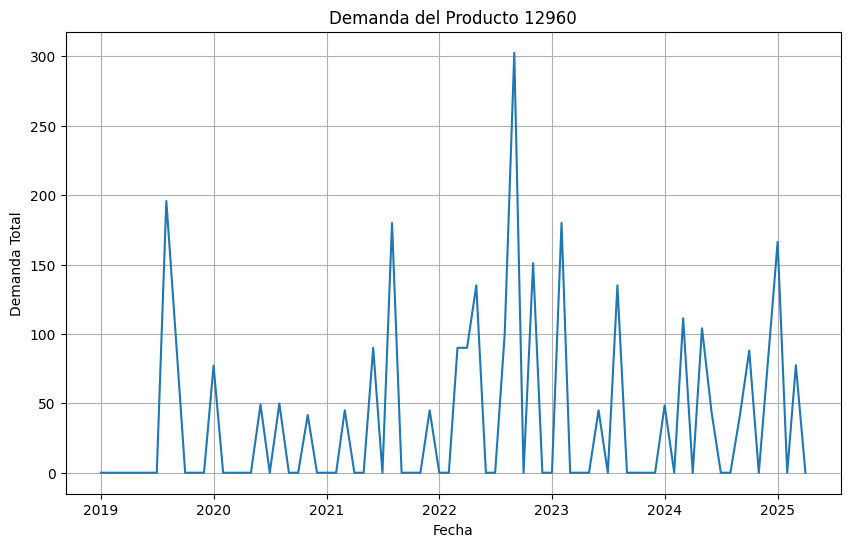

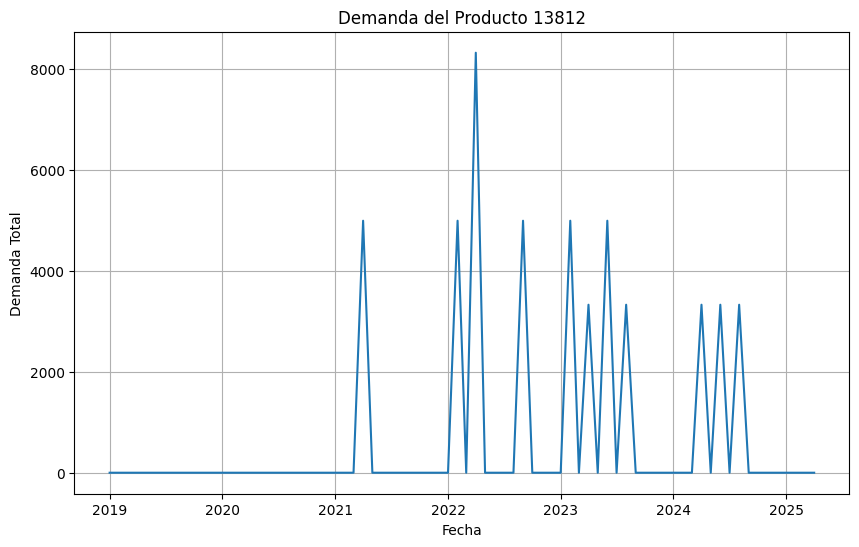

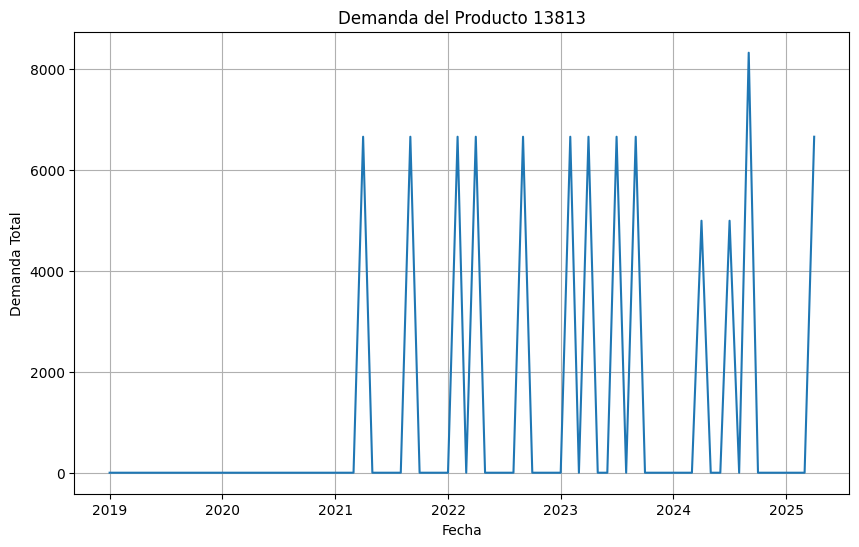

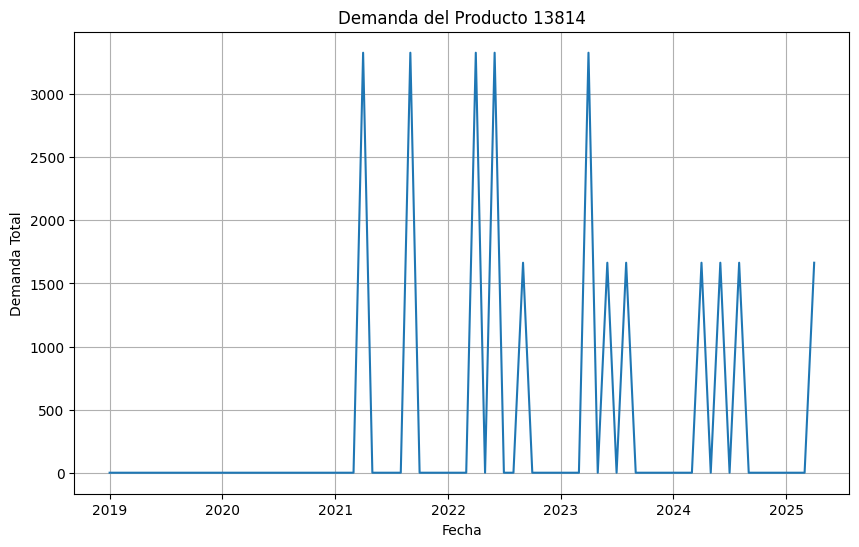

In [13]:
# Graficar la demanda totoal para los primeros productos
product_codes = df['PRODUCT_CODE'].unique()[:5]  # Solo graficamos los primeros 5 productos

for code in product_codes:
    product_data = df_full[df_full['PRODUCT_CODE'] == code]
    plt.figure(figsize=(10, 6))
    plt.plot(product_data['DATE'], product_data['TOTAL_AMOUNT'])
    plt.title(f'Demanda del Producto {code}')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda Total')
    plt.grid(True)
    plt.show()

In [14]:
# ==================================================================================================== #
# 6. AGRUPACIÓN POR PRODUCTO
# ==================================================================================================== #

In [15]:
# Dado que tenemos datos para múltiples productos, puede ser útil agrupar los datos por PRODUCT_CODE para tratar cada producto como una serie temporal independiente.

# Agrupar los datos por código de producto
grouped = df_full.groupby('PRODUCT_CODE')

# Ejemplo: Obtener los datos para un producto específico
# product_data = grouped.get_group(12808) # Reemplaza 12808 por el código de producto de tu interés
# print(product_data.head())

In [16]:
# ==================================================================================================== #
# 7. GUARDAR EL DATAFRAME PREPROCESADO (OPCIONAL)
# ==================================================================================================== #

In [17]:
# # Guardar el DataFrame completo con los registros faltantes como un archivo Excel
# df_full.to_excel("preprocessed_noel_data.xlsx", index=False)

# # Este código guardará el DataFrame como un archivo Excel llamado preprocessed_data.xlsx en el directorio actual de trabajo. 
# # Cuando cargues este archivo en el futuro, el DataFrame mantendrá la misma estructura, sin necesidad de ajustes adicionales.

In [18]:
# # Cargar el archivo
# df_full_loaded = pd.read_excel("preprocessed_noel_data.xlsx")

# # Verificar que el DataFrame cargado sea el mismo
# print(df_full_loaded.head())

In [19]:
# ==================================================================================================== #
# ==================================================================================================== #
# PREPROCESAMIENTO DE LOS DATOS
# ==================================================================================================== #
# ==================================================================================================== #

1. **División de los datos en entrenamiento y prueba**
Para evaluar el rendimiento de los modelos de forecasting, necesitamos dividir los datos en **entrenamiento** y **prueba**. En series temporales, es crucial respetar el orden temporal, por lo que utilizaremos una **división temporal** en lugar de una división aleatoria.

Vamos a usar el método `train_test_split` temporal de `sktime` o `TimeSeriesSplit` de `scikit-learn`.

2. **Prueba de Modelos**
Vamos a probar algunos modelos populares para series temporales de demanda intermitente:

**Modelos Estadísticos**:
- **Método de Croston** (para demanda intermitente)
- **ARIMA** (si la serie tiene tendencia o estacionalidad)

**Modelos de Machine Learning**:
- **LightGBM**: Usando características temporales.
- **XGBoost**: Otro algoritmo de boosting popular.
- **Random Forest**: Modelo robusto para capturar de patrones complejos.

**Deep Learning**:
- **LSTM**: Si tenemos suficientes datos, este modelo es adecuado para capturar dependencias de largo plazo.

3. **Evaluación de los Modelos**
Vamos a utilizar métricas como MAE, RMSE y MAPE para evaluar el rendimiento de los modelos. Estas métricas son adecuadas para la predicción de series temporales.